- Linear regression & Titanic
- Florent Dufour
- 2016 - 2022

In [ ]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

from IPython.display import clear_output

In [ ]:
# Titanic dataset
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv") # Training
dfeval  = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")  # Testing
y_train = dftrain.pop("survived") # Pop survived column in y_train
y_eval  = dfeval.pop("survived")  # Pop survived column in y_eval

## Exploration of the dataset

- Most passengers are in their mid 20s
- Most passengers are male
- Most passengers are in Third class
- Survival reate is much higher for females

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape # 627 entries, 9 features

(627, 9)

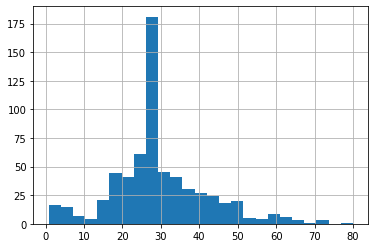

In [ ]:
# Distribution by age
dftrain.age.hist(bins=25) # Most people in mid 20s

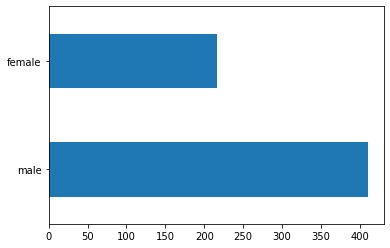

In [ ]:
# Distribution by sex
dftrain.sex.value_counts().plot(kind='barh')

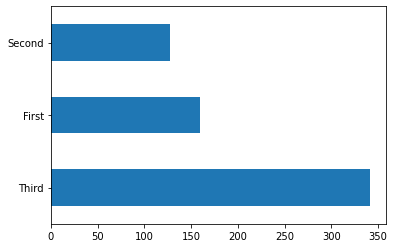

In [ ]:
# Distribution by class
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% Survive')

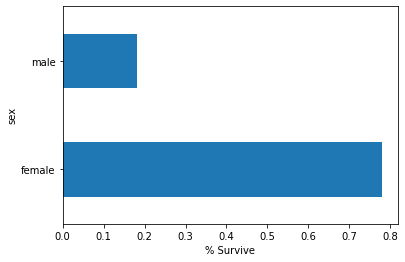

In [ ]:
# Survival by sex
pd.concat(
    [dftrain, y_train],
    axis=1
).groupby('sex').survived.mean().plot(kind="barh").set_xlabel("% Survive")

# Linear regression

- Be as close as possible to each data point
- Get as many data points on the left as on the right of the line



\





In [ ]:
# Create feature columns

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [ ]:
# Before creating the model
# We need to create an input function with the appropriate `tf.data.Dataset` object to feed the model
# Load data in *batches*: Not one by one (too slow), not everything at once (maynot fit in RAM)

def make_input_fn(data_df, label_df, num_epochs=50, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [ ]:
# Train and evaluate

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn) # Train
result = linear_est.evaluate(eval_input_fn) # Evaluate

clear_output()
result['accuracy']

0.78409094

In [ ]:
# Make a prediction

result = list(linear_est.predict(eval_input_fn)) # List of dicts of all predictions
clear_output()

person_to_lookup = 2
print("the person...", dfeval.loc[person_to_lookup])
print("...did survive?", y_eval.loc[person_to_lookup])
print("We estimated with probability:", result[person_to_lookup]['probabilities']) # index 0: Not surviving / 1 surviving

the person... sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
...did survive? 1
We estimated with probability: [0.33121654 0.6687834 ]
